# Black-Scholes Autodifferentiation Example

In this example we are calculating  values using the Black-Scholes model.

In [1]:
# Imports & Constants
import tributary.streaming as ts
import math
import matplotlib.pyplot as plt
import asyncio

TRADING_DAYS = 252

## We can use the tributary $\textit{Erf}$ operator to define a Standard Normal CDF

The CDF is defined using $\Phi(x, \mu, \sigma) = \frac{1}{2}\left(1 + Erf\left(\frac{x-\mu}{\sigma\sqrt{2}}\right)\right)$ for $\mu = 0, \sigma = 1$

In [2]:
def normal_cdf(x):
    return (
        (
            ts.Erf(x / ts.Const((math.sqrt(2), 0), use_dual=True)) + ts.Const((1,0), use_dual=True)
        ) / ts.Const((2,0), use_dual=True)
    )

### Now we can define our streams

For this example we are going use a Call Option.

We define the model as follows:
$C_p = S\Phi(d_1) - Xe^{-rt}\Phi(d_2)$

$d_1 = \frac{ln\left(\frac{S}{X}\right) + \left(r + \frac{\sigma^2}{2}\right)t}{\sigma\sqrt{t}}$

$d_2 = d_1 - \sigma\sqrt{t}$

Where

$C_p$ - Price of Call Option

$S$ - Stock Price

$X$ - Strike Price

$r$ - Risk Free Interest Rate

$\sigma$ - Stock Price Volatility

$t$ - Time to Maturity

$\Phi$ - Standard Normal CDF (defined above)



In [3]:
def _time():
    for _ in [1, 2, 3, 4, 5, 6, 7]:
        yield (_, 1)

strike_price = ts.Const((203,0), use_dual=True)
stock_price = ts.Const((210,0), use_dual=True)

r = ts.Const((0.2175, 0), use_dual=True)

time = ts.Node(func=_time, name='Time', use_dual=True) / ts.Const((TRADING_DAYS, 0), use_dual=True)

vol = ts.Const((14.04, 0), use_dual=True)
   

d1 = (((ts.Log(stock_price / strike_price) + time * (r + vol**2 / ts.Const((2,0), use_dual=True)))
       / vol*ts.Sqrt(time)))

d2 = d1 - vol*ts.Sqrt(time)

opt_price_streaming = stock_price * normal_cdf(d1) - strike_price * ts.Exp(ts.Negate(r * time)) * normal_cdf(d2)

In [4]:
opt_price_streaming.dagre()

DagreD3Widget()

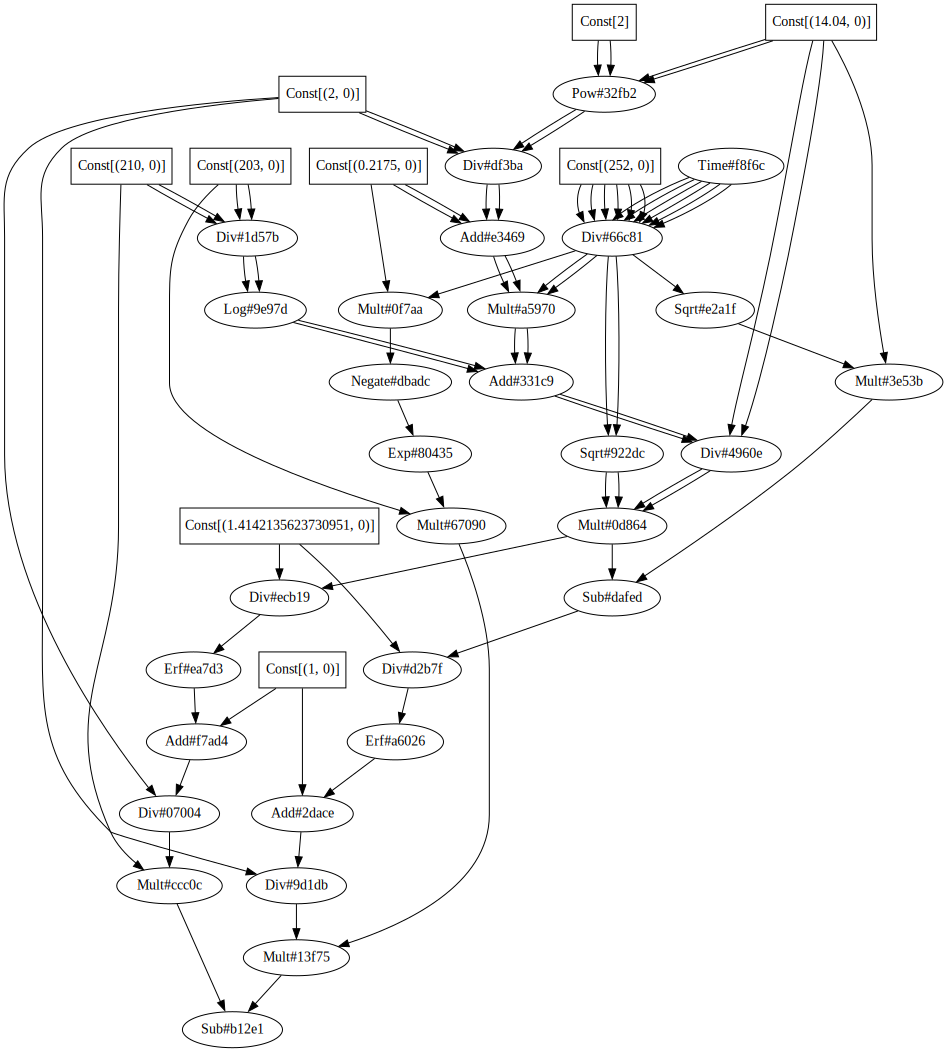

In [4]:
# for static export
opt_price_streaming.graphviz()

In [5]:
### Run It
out_streaming = ts.run(opt_price_streaming)

In [6]:
out_streaming.result()

[(66.8776611932584, 24.352198840905817),
 (83.86128300705717, 11.832703898921917),
 (92.84070745210619, 6.752389217848223),
 (98.17842047720399, 4.188980644378843),
 (101.5952528598688, 2.7777662485790917),
 (103.93099724868352, 1.9662389828058664),
 (105.63795822831602, 1.4892578664798224)]

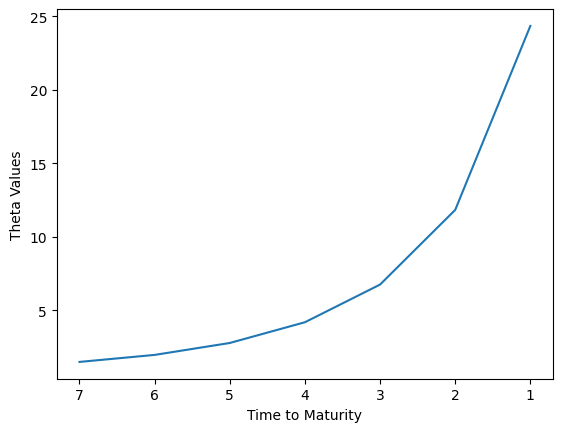

In [7]:
thetas = [x[1] for x in out_streaming.result()]
plt.plot([x[0] for x in _time()], thetas)
plt.xlabel('Time to Maturity')
plt.ylabel('Theta Values')
plt.gca().invert_xaxis()

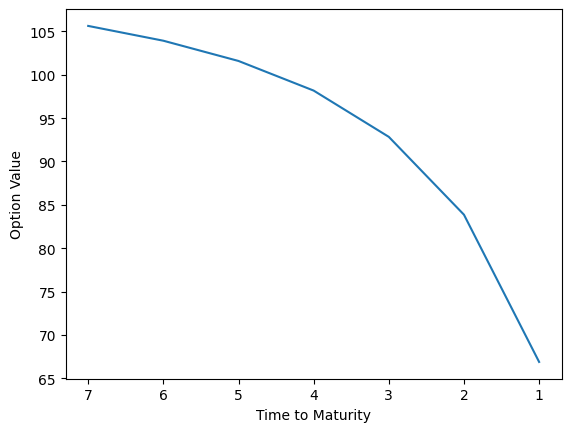

In [8]:
option_value = [x[0] for x in out_streaming.result()]
plt.plot([x[0] for x in _time()], option_value)
plt.xlabel('Time to Maturity')
plt.ylabel('Option Value')
plt.gca().invert_xaxis()

# Symbolic Construction

In [9]:
import numpy as np
import sympy as sy
from IPython.display import display, HTML
from sympy.stats import Normal as syNormal, cdf
sy.init_printing()

# adapted from https://gist.github.com/raddy/bd0e977dc8437a4f8276
#spot, strike, vol, days till expiry, interest rate, call or put (1,-1)
spot, strike, vol, dte, rate, cp = sy.symbols('spot strike vol dte rate cp')

T = dte / 260.
N = syNormal('N', 0.0, 1.0)

d1 = (sy.ln(spot / strike) + (0.5 * vol ** 2) * T) / (vol * sy.sqrt(T))
d2 = d1 - vol * sy.sqrt(T)

TimeValueExpr = sy.exp(-rate * T) * (cp * spot * cdf(N)(cp * d1) - cp * strike  * cdf(N)(cp * d2))

In [10]:
TimeValueExpr

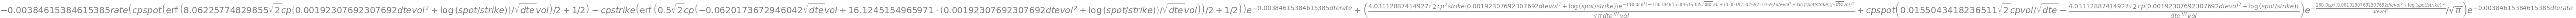

In [11]:
# Take derivative with respect to time
DeltaExpr = TimeValueExpr.diff(dte)
DeltaExpr

In [12]:
import tributary.symbolic as ts
import tributary.streaming as tss
PriceClass = ts.construct_streaming(TimeValueExpr)


def strikes():
    strike = 205
    while strike < 220:
        yield strike
        strike += 2.5

price = PriceClass(spot=tss.Const(210.59),
                   strike=tss.Func(strikes),
                   vol=tss.Const(14.04),
                   dte=tss.Const(4),
                   rate=tss.Const(.2175),
                   cp=tss.Const(-1))

In [21]:
price.dagre()

DagreD3Widget()

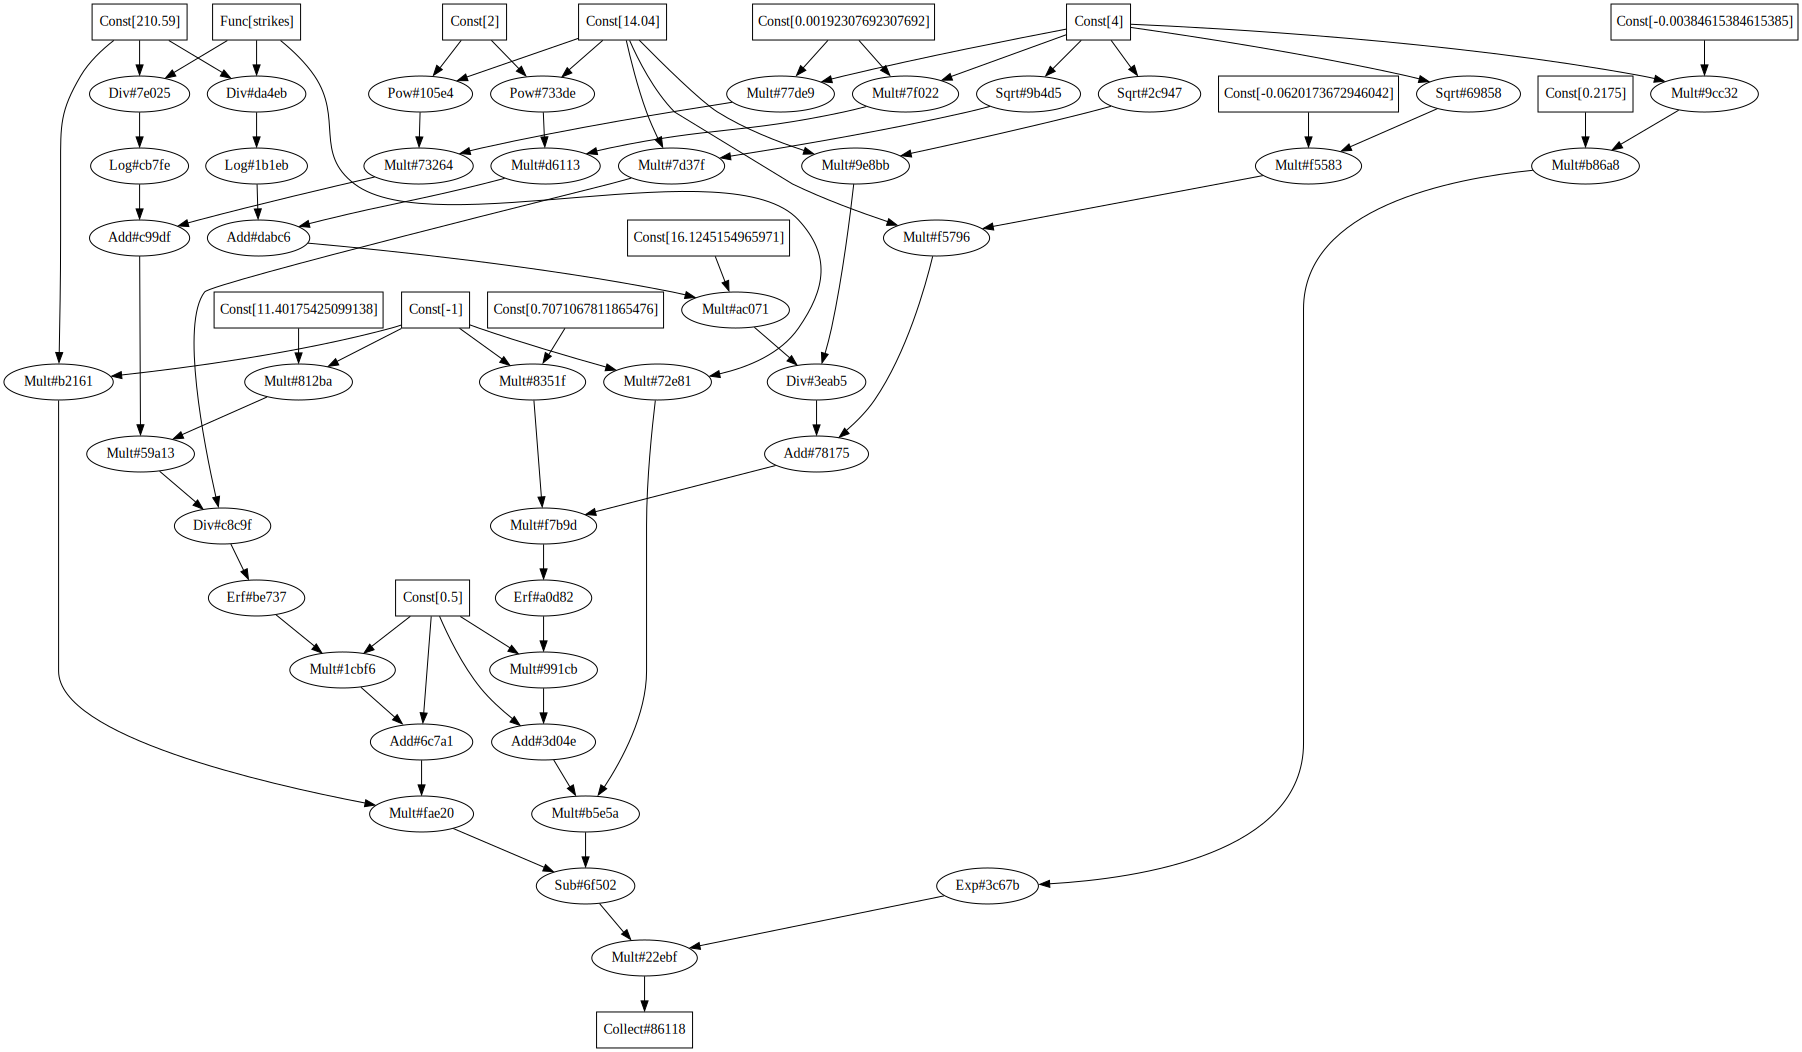

In [13]:
price.graphviz()

In [14]:
DeltaClass = ts.construct_streaming(DeltaExpr)

delta = DeltaClass(spot=tss.Const(210.59),
                   strike=tss.Func(strikes),
                   vol=tss.Const(14.04),
                   dte=tss.Const(4),
                   rate=tss.Const(.2175),
                   cp=tss.Const(-1))

In [20]:
delta.dagre()

DagreD3Widget()

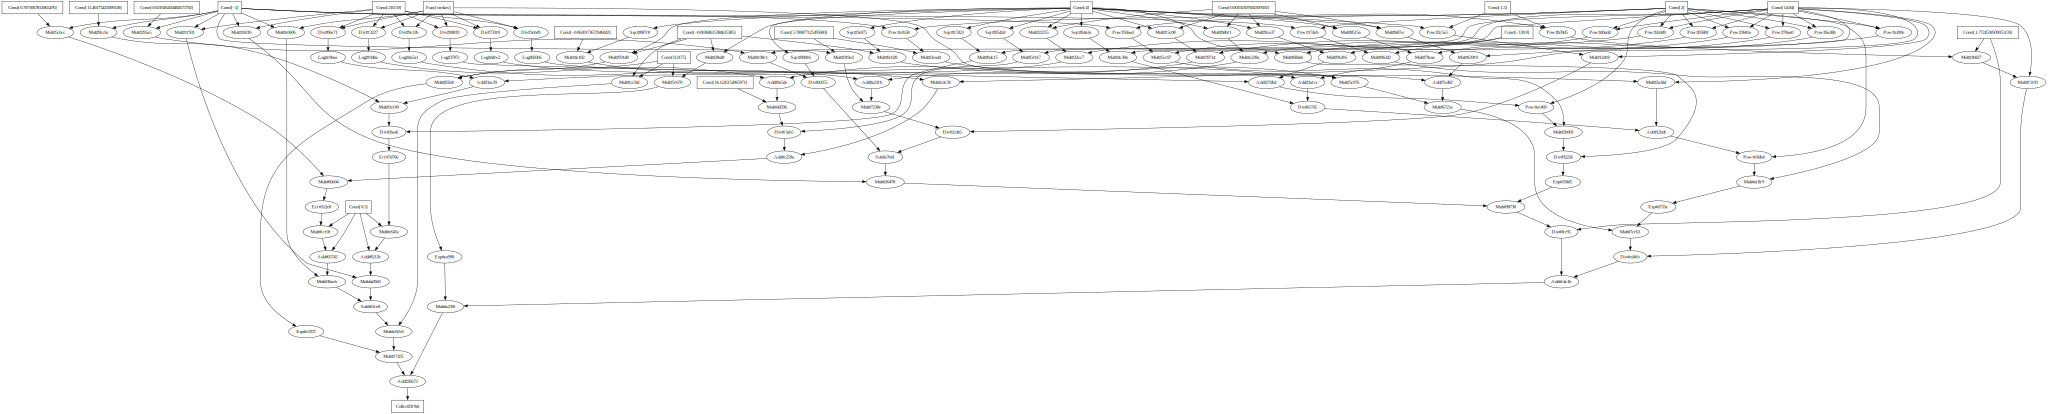

In [15]:
delta.graphviz()

In [16]:
price_res = price.run()

In [17]:
price_res.result()

In [18]:
delta_res = delta.run()

In [19]:
delta_res.result()